# Data Import

In [59]:
import sqlite3
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

if os.getenv("SNAKEMAKE_EXECUTION"):
    # Adjust paths for Snakemake execution
    output = "./05-logistic_regression/roc.pdf"
    db_path = "./unified-final.db"
else:
    # Adjust paths for local execution
    output = "roc.pdf"
    db_path = "../unified-final.db"



con = sqlite3.connect(db_path)
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM prod_desc", con)
df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, "little"))
df =  df.drop(columns=['level_0','index'])
df.shape

(11521, 218)

# Feature  Selection

seperate target variable

In [60]:
y = df['AB']
df = df.drop(columns='AB')
df.shape

(11521, 217)

Drop non numeric columns

In [61]:
df = df.select_dtypes(include=[float, int])
df.shape

(11521, 210)

Drop features with 0 variance

In [62]:
df = df.loc[:, df.var() > 0]
df.shape

(11521, 141)

Drop correlated features. (This would otherwise make problems with regularisation and convergence of regression)

In [63]:
# copy paste from https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
import numpy as np

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)
df.shape

(11521, 31)

Drop rows containing nan

In [64]:
df = df.dropna(axis = 0)
df.shape

(11521, 31)

# Fit and cross validation

In [65]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(df,y)

model.coef_

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

This did not work. To get the regression to convergence, the features are scaled.

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
scaled_df = scaled_df.dropna(axis=1)
scaled_df.shape

(11521, 30)

Retry fit

In [67]:
model.fit(scaled_df,y)
model.coef_


array([[ 0.03458831,  0.0034941 ,  0.77052332,  0.04293006, -0.39052505,
         1.14037754,  0.0990966 ,  0.14291727, -0.0108498 ,  0.01807766,
        -0.01318614, -0.14214012,  0.0219423 , -0.05526728,  0.08521502,
         0.09003887, -0.39779827,  0.10157997, -0.10284163, -0.3241462 ,
        -0.07902548, -0.0659901 ,  0.46133087,  0.26105425,  0.09932128,
        -0.04621585,  0.11626639, -0.08822864,  0.07752927, -0.55528444]])

Now that we have achieved convergence we can properly crossvalidate this model.

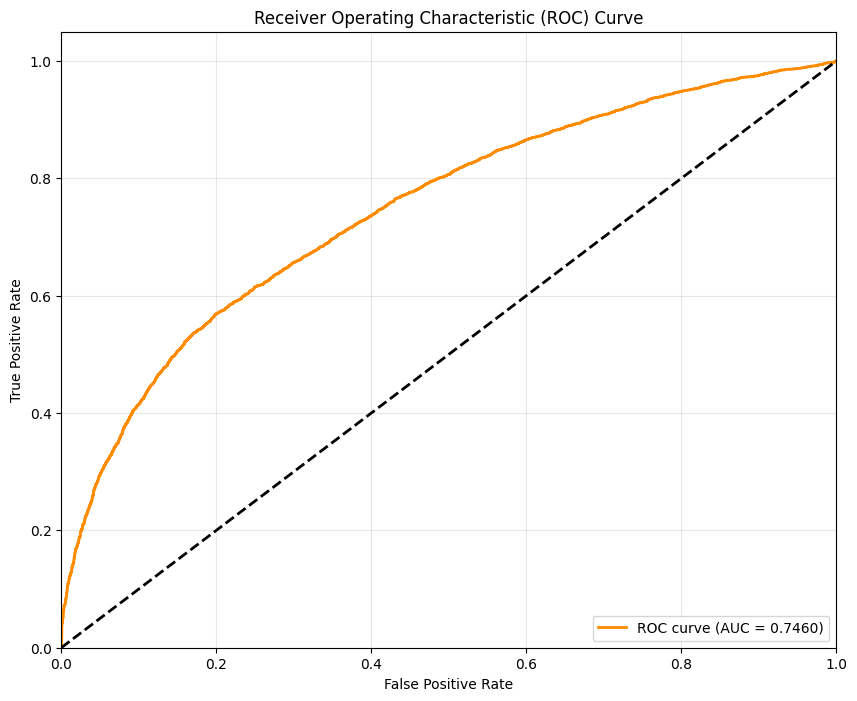


Classification Report:
              precision    recall  f1-score       support
0              0.652044  0.621083  0.636187   5265.000000
1              0.693360  0.721068  0.706942   6256.000000
accuracy       0.675375  0.675375  0.675375      0.675375
macro avg      0.672702  0.671075  0.671565  11521.000000
weighted avg   0.674479  0.675375  0.674608  11521.000000

Cross-validation Accuracy Scores: [0.67158351 0.69965278 0.67664931 0.66666667 0.66232639]
Mean CV Accuracy: 0.6753757305977344
Standard Deviation of CV Accuracy: 0.013049988754878051

Detailed Cross-Validation Report:
      Fold  Accuracy
0        1  0.671584
1        2  0.699653
2        3  0.676649
3        4  0.666667
4        5  0.662326
Mean  Mean  0.675376
Std    Std  0.013050


In [68]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

X = scaled_df

# Define the LogisticRegressionCV model
log_reg_cv = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)

# Perform cross-validation and get predictions
y_pred_prob = cross_val_predict(log_reg_cv, X, y, cv=5, method='predict_proba')[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
plt.savefig(output)

# Generate classification report
y_pred_labels = cross_val_predict(log_reg_cv, X, y, cv=5)
report = classification_report(y, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display the classification report
print("\nClassification Report:")
print(report_df)

# Get cross-validation scores (accuracy)
cv_scores = cross_val_score(log_reg_cv, X, y, cv=5, scoring='accuracy')

# Display cross-validation scores
print("\nCross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation of CV Accuracy:", np.std(cv_scores))

# Generate a detailed cross-validation report
cv_report = {
    "Fold": list(range(1, 6)),
    "Accuracy": cv_scores
}

cv_report_df = pd.DataFrame(cv_report)
cv_report_df.loc["Mean"] = ["Mean", np.mean(cv_scores)]
cv_report_df.loc["Std"] = ["Std", np.std(cv_scores)]

print("\nDetailed Cross-Validation Report:")
print(cv_report_df)
